In [172]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Circle, Rectangle
from matplotlib.collections import LineCollection

In [173]:
def line_intersect(p1, p2, P3, P4):
    # calcule les coordonnées des points d'intersections entre deux segments. Ici entre le rayon du senseur et du mur

    # on récupère les coodonnées de tous les segments que formé par les senseurs
    p1 = np.atleast_2d(p1) 
    p2 = np.atleast_2d(p2)
    # on récupère les coordonnées des segments des murs du labyrinthe
    P3 = np.atleast_2d(P3)
    P4 = np.atleast_2d(P4)
    

    x1, y1 = p1[:,0], p1[:,1]
    x2, y2 = p2[:,0], p2[:,1]
    X3, Y3 = P3[:,0], P3[:,1]
    X4, Y4 = P4[:,0], P4[:,1]

    #colinéarité entre le vecteur senseur et le mur 
    D = (Y4-Y3)*(x2-x1) - (X4-X3)*(y2-y1)

    # Colinearity test
    C = (D != 0)
    UA = ((X4-X3)*(y1-Y3) - (Y4-Y3)*(x1-X3))
    UA = np.divide(UA, D, where=C)
    UB = ((x2-x1)*(y1-Y3) - (y2-y1)*(x1-X3))
    UB = np.divide(UB, D, where=C)

    # Test if intersections are inside each segment
    C = C * (UA > 0) * (UA < 1) * (UB > 0) * (UB < 1)
    
    X = np.where(C, x1 + UA*(x2-x1), np.inf)
    Y = np.where(C, y1 + UA*(y2-y1), np.inf)
    return np.stack([X,Y],axis=1)

In [174]:
class Maze:
    """
    A simple 8-maze made of straight walls (line segments)
    """

    def __init__(self):
        self.walls = np.array( [

            # Surrounding walls
            [ (  0,   0), (  0, 500)],
            [ (  0, 500), (300, 500)],
            [ (300, 500), (300,   0)],
            [ (300,   0), (  0,   0)],
            
            # Bottom hole
            [ (100, 100), (200, 100)],
            [ (200, 100), (200, 200)],
            [ (200, 200), (100, 200)],
            [ (100, 200), (100, 100)],

            # Top hole
            [ (100, 300), (200, 300)],
            [ (200, 300), (200, 400)],
            [ (200, 400), (100, 400)],
            [ (100, 400), (100, 300)],

            # Moving walls (invisibles) to constraing bot path
            [ (  0, 250), (100, 200)],
            [ (200, 300), (300, 250)] 
        ] )

In [175]:
class Bot:
    
    def __init__(self):
        self.size = 10
        self.position = 150,250
        self.orientation = 0
        self.n_sensors = 8
        self.delta_theta=0
        self.tour=0
        A = np.linspace(-np.pi/2, +np.pi/2, self.n_sensors+2, endpoint=True)[1:-1]
        self.sensors = {
            "angle" : A,
            "range" : 75*np.ones((self.n_sensors,1)),
            "value" : np.ones((self.n_sensors,1)) }

    def draw(self, ax):

        # Sensors
        n = 2*len(self.sensors["angle"])
        sensors = LineCollection(np.zeros((n,2,2)),
                                 colors = ["0.75", "0.00"] * n,
                                 linewidths = [0.75, 1.00] * n,
                                 linestyles = ["--", "-"] * n)
        # Body 
        body = Circle(self.position, self.size, zorder=20,
                      edgecolor="black", facecolor=(1,1,1,.75))

        # Head
        P = np.zeros((1,2,2))
        P[0,0] = self.position
        P[0,1] = P[0,1] + self.size * np.array([np.cos(self.orientation),
                                                np.sin(self.orientation)])

    
    def update(self, maze):
        # Sensors
        A = self.sensors["angle"] + self.orientation # angles de tous les senseurs
        print(A)
        T = np.stack([np.cos(A), np.sin(A)], axis=1) # gradient ? de tous les angles des senseurs
        P1 = self.position + self.size*T # positions dans le plan de tous les senseurs du robot
        P2 = P1 + self.sensors["range"]*T # coordonées de la fin du segment formé a partir du senseur et jusq'uà sa distance de vision
        P3, P4 = maze.walls[:,0], maze.walls[:,1] # coordonnées de tous les murs du labyrinthe 
        for i, (p1, p2) in enumerate(zip(P1,P2)): # pour tous les segments robot-range 
            C = line_intersect(p1, p2, P3, P4) # calcul du point d'intersection entre la vision et le mur du labyrinthe
            index = np.argmin( ((C - p1)**2).sum(axis=1)) # somme des distances au carré du robot aux intersections, on obtient le nom du senseur de plus petit distance au mur 
            p = C[index] # on récupère la plus petite distance au mur
            if p[0] < np.inf: # si la distance est finie alors:
                self.sensors["value"][i] = np.sqrt(((p1-p)**2).sum())
                self.sensors["value"][i] /= self.sensors["range"][i]
                #self.sensors["value"][i]+=np.random.normal(loc=0,scale=0.5)
            else:
                self.sensors["value"][i] = 1

In [176]:
def update():
    bot.delta_theta = (bot.sensors["value"].ravel() * [-4,-3,-2,-1,1,2,3,4]).sum()
    print(bot.sensors["value"])
    if abs(bot.delta_theta) > 0.5:
        bot.orientation += 0.01 * bot.delta_theta
    else: bot.delta_theta=0
    bot.position += 2 * np.array([np.cos(bot.orientation),
                                  np.sin(bot.orientation)])
    bot.update(maze)

    # Moving walls
    if bot.position[1] < 100 :
        maze.walls[12:] = [[(0, 250), (100, 300)], [(200, 200), (300, 250)]]
    elif bot.position[1] > 400:
        maze.walls[12:] = [[(0, 250), (100, 200)], [(200, 300), (300, 250)]]
    return 
    

In [177]:
#on construit le data set pour entrainer le modèle, 10_000 données recoupant les valeurs des senseurs, le theta, la position

# initialisation des variables
maze = Maze()
bot = Bot()
bot.position = 150, 250
bot.orientation = 0
bot.sensors["range"][3:5] *= 1.25
bot.tour=0
set_size= 10000
#  création du tableau 
set=np.zeros((set_size+1,4))
n=0

for i in range(set_size):
    sensors_data=bot.sensors["value"].ravel()
    print(sensors_data)
    delta_theta= [bot.delta_theta]
    orientation=[bot.orientation]
    position= bot.position
    if 149<position[0]<151 and 200<position[1]<300 and i>2:
        bot.tour+=1
        tour=[bot.tour]
        if bot.tour==2:
            completed_tour=i
            print(completed_tour)
    else: tour=[0]
    set[i]=np.concatenate((bot.position,delta_theta,orientation))
    update()

[1. 1. 1. 1. 1. 1. 1. 1.]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[-1.22173048 -0.87266463 -0.52359878 -0.17453293  0.17453293  0.52359878
  0.87266463  1.22173048]
[0.57611851 0.73693819 1.         1.         1.         0.92417281
 0.73693819 0.57611851]
[[0.57611851]
 [0.73693819]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.92417281]
 [0.73693819]
 [0.57611851]]
[-1.22173048 -0.87266463 -0.52359878 -0.17453293  0.17453293  0.52359878
  0.87266463  1.22173048]
[0.57611851 0.73693819 1.         1.         1.         0.90988219
 0.73693819 0.57611851]
[[0.57611851]
 [0.73693819]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.90988219]
 [0.73693819]
 [0.57611851]]
[-1.22173048 -0.87266463 -0.52359878 -0.17453293  0.17453293  0.52359878
  0.87266463  1.22173048]
[0.57611851 0.73693819 1.         1.         1.         0.89559157
 0.73693819 0.57611851]
[[0.57611851]
 [0.73693819]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.89559157]
 [0.73693819]
 [0.57611851]]
[-1.22173048 -0.

In [178]:
set[0,:]

array([150., 250.,   0.,   0.])

In [179]:
wal = np.array( [

            # Surrounding walls
            [ (  0,   0), (  0, 500)],
            [ (  0, 500), (300, 500)],
            [ (300, 500), (300,   0)],
            [ (300,   0), (  0,   0)],
            
            # Bottom hole
            [ (100, 100), (200, 100)],
            [ (200, 100), (200, 200)],
            [ (200, 200), (100, 200)],
            [ (100, 200), (100, 100)],

            # Top hole
            [ (100, 300), (200, 300)],
            [ (200, 300), (200, 400)],
            [ (200, 400), (100, 400)],
            [ (100, 400), (100, 300)]
        ] )

In [180]:
set[0,0:1]

array([150.])

In [181]:
print(bot.sensors["range"])
bot.sensors["range"]=75*np.ones((8,1))
bot.sensors["range"][3:5]*=1.25
bot.sensors["value"]=np.ones((bot.n_sensors,1))
print(bot.sensors["value"])
data_set=np.zeros((set_size,12))
for i in range(set_size):
        
        A = bot.sensors["angle"] + set[i,3] # angles de tous les senseurs
        T = np.stack([np.cos(A), np.sin(A)], axis=1) # gradient ? de tous les angles des senseurs
        P1 = set[i,0:2]+ bot.size*T # positions dans le plan de tous les senseurs du robot
        P2 = P1 + bot.sensors["range"]*T # coordonées de la fin du segment formé a partir du senseur et jusq'uà sa distance de vision
        P3, P4 = wal[:,0], wal[:,1] # coordonnées de tous les murs du labyrinthe 
        for n, (p1, p2) in enumerate(zip(P1,P2)): # pour tous les segments robot-range 
            C = line_intersect(p1, p2, P3, P4) # calcul du point d'intersection entre la vision et le mur du labyrinthe
            index = np.argmin( ((C - p1)**2).sum(axis=1)) # somme des distances au carré du robot aux intersections, on obtient le nom du senseur de plus petit distance au mur 
            p = C[index] # on récupère la plus petite distance au mur
            if p[0] < np.inf: # si la distance est finie alors:
                bot.sensors["value"][n] = np.sqrt(((p1-p)**2).sum())+np.random.normal(loc=0,scale=0.5)
                bot.sensors["value"][n] /= bot.sensors["range"][n]
            else:
                bot.sensors["value"][n] = 1
            bot.sensors["value"][n]
        data_set[i,0:8]=bot.sensors["value"].reshape((8,))
        data_set[i,8]=set[i,2]
        data_set[i,9],data_set[i,10]=set[i,0],set[i,1]
        data_set[i,11]=set[i,3]

[[75.  ]
 [75.  ]
 [75.  ]
 [93.75]
 [93.75]
 [75.  ]
 [75.  ]
 [75.  ]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [182]:
np.shape(data_set)

(10000, 12)

In [183]:

np.save('data_set bretenberg.npy',data_set)

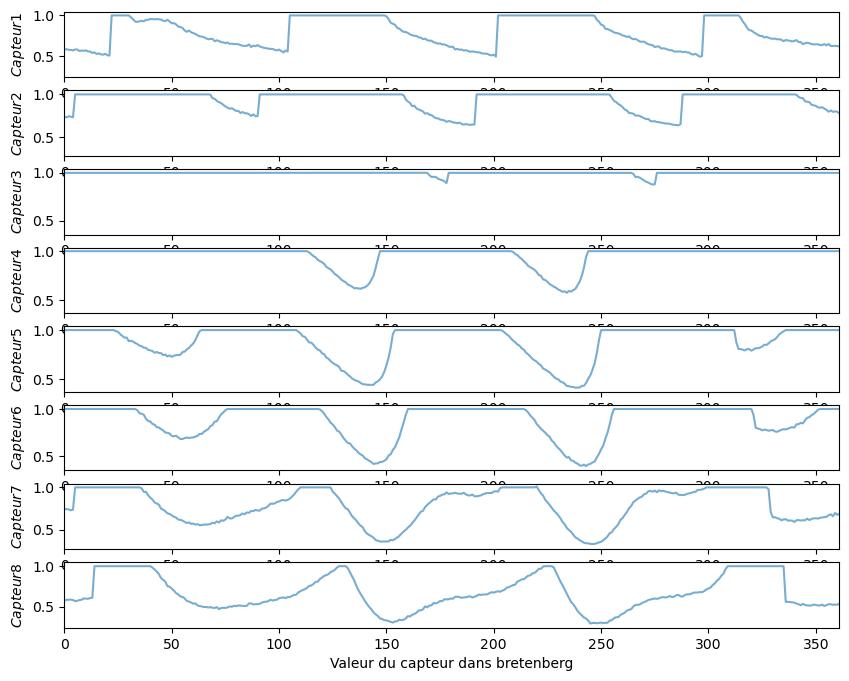

In [184]:

plt.figure(figsize=(10, 8))
for i in range(bot.n_sensors):
    plt.subplot(bot.n_sensors, 1, i+1)
    plt.plot(data_set[:,i], alpha=0.6)
    plt.ylabel(f"$Capteur{i+1}$")
    plt.xlim((0,361))
plt.xlabel(f"Valeur du capteur dans bretenberg")
plt.show()

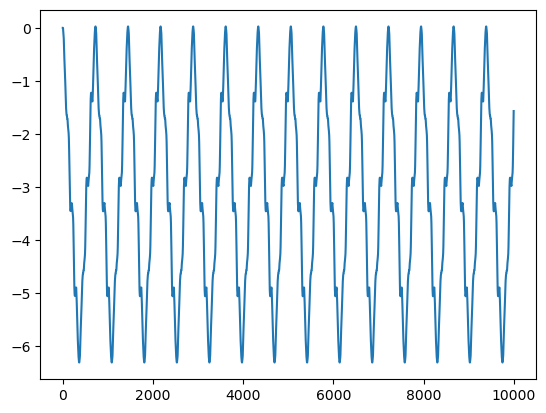

In [185]:
plt.plot(data_set[:,11])

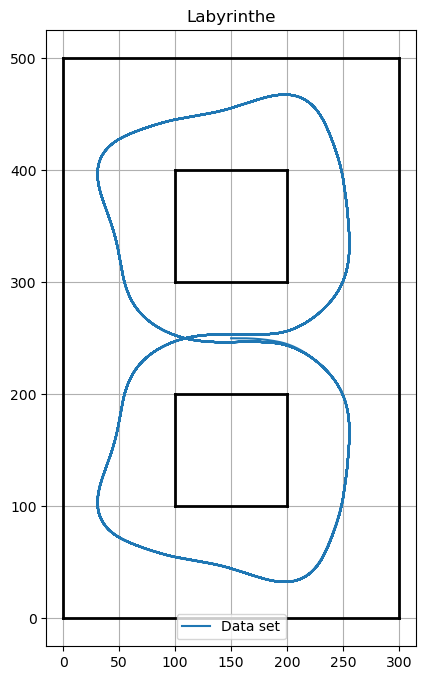

In [186]:
fig, ax = plt.subplots(figsize=(8, 8))

# Tracé des murs
for wall in maze.walls[:12]:
    (x1, y1), (x2, y2) = wall
    ax.plot([x1, x2], [y1, y2], 'k-', linewidth=2)

# Tracé de la trajectoire du robot
ax.plot(data_set[:,9],data_set[:,10],label='Data set')

# Options d'affichage
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 500)
ax.set_aspect('equal')
ax.set_title('Labyrinthe')
ax.legend()
plt.grid(True)
plt.show()

In [187]:
data_set[9999,9:11]

array([ 30.7006378 , 395.48405504])